In [1]:
import glob
import japanize_matplotlib
import os
import pandas as pd
import random
import sys
import math
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
def return_fixed_class(BenchMark="bt", Processes=[1, 2, 4, 8, 16, 32, 64, 128, 256], FixedBenchMarkClass="C"):
        path = './'
        
        # fixed_Class にはベンチマーククラスFixedBenchMarkClassで実行プロセス数がProcessesに該当するものの結果が入る
        fixed_Class = list()

        for process in Processes:
            file_name = ("pprof_"+BenchMark+FixedBenchMarkClass+str(process)+".csv")
            file_path = path+file_name
            if (os.path.exists(file_path) and os.stat(file_path).st_size != 0):
                data_frame = pd.read_csv(path+file_name)
                data_frame = data_frame.set_index(['Name'])
                fixed_Class.append(data_frame.rename(columns = {'#Call': process}).sort_index())
        return(fixed_Class)
    

In [3]:
def return_fixed_process(BenchMark="bt", BenchMarkClasses=["S", "W", "A", "B", "C", "D"], FixedProcess=32):
    path = './'

    # fixed_process には実行プロセス数が64でベンチマーククラスがA ~ Dまでの結果が入る
    fixed_process = list()

    for bench_mark_class in BenchMarkClasses:
        file_name = ("pprof_"+BenchMark+bench_mark_class+str(FixedProcess)+".csv")
        file_path = path+file_name
        if (os.path.exists(file_path) and os.stat(file_path).st_size != 0):
            data_frame = pd.read_csv(path+file_name)
            data_frame = data_frame.set_index(['Name'])
            fixed_process.append(data_frame.rename(columns = {'#Call': bench_mark_class}).sort_index())
    return(fixed_process)
       

In [4]:
BenchMark_name = "cg"
cg_fixed_class = return_fixed_class(BenchMark=BenchMark_name)
cg_fixed_process = return_fixed_process(BenchMark=BenchMark_name)
summary_fixed_class = pd.concat(cg_fixed_class, axis=1)

columns = summary_fixed_class.columns.to_numpy()

index = summary_fixed_class.index.to_numpy()

dict_summary_fixed_class = {"benchmarks": columns}
for index_name in index:
    dict_summary_fixed_class[index_name] = summary_fixed_class.T[index_name].to_numpy()

In [5]:
# x軸, y軸ともに対数にしようとしてみる

# 対数化に必要なので導入
import sklearn.preprocessing as sp
from sklearn.metrics import r2_score

# 常用対数の逆関数
def inverter_log10_func(x):
    return 10**x

# transformer_log10 : 渡された値に対して一括して常用対数をとるメソッド?
transformer_log10 = sp.FunctionTransformer(func=np.log10, inverse_func=inverter_log10_func)

# 引数として学習用のx, yがあり、線形関数として学習したモデルを返す
def return_lr_lin(input_x, input_y):
    lr = LinearRegression()
    lr.fit(input_x, input_y)
    return lr

# 引数として学習用のx, yをとり、非線形関数として学習したモデルを返す
def return_lr_log10(input_x, input_y):
    # N_train_log10 : 学習用のデータに常用対数をとったもの
    x_train_log10 = transformer_log10.transform(input_x)
    y_train_log10 = transformer_log10.transform(input_y)
    # 線形回帰モデルの生成
    lr = LinearRegression()
    # 学習
    lr.fit(x_train_log10, y_train_log10)
    return lr

# 引数としてテスト用のx, y、線形関数として学習したモデルlrをとり、スコアを返す
def return_lr_lin_score(input_x, input_y, lr):
    y_predict = lr.predict(input_x)
    _r2_score = r2_score(input_y, y_predict)
    return _r2_score

# 引数としてテスト用のx, y、非線形関数として学習したモデルlrをとり、スコアを返す
def return_lr_log10_score(input_x, input_y, lr):
    # N_predict : モデル式を引くためのデータ, N_predict_log10 : モデル式を引くためのデータに常用対数をとったもの
    input_x_log10 = transformer_log10.transform(input_x)
    y_predict_log10 = lr.predict(input_x_log10)
    y_predict = transformer_log10.inverse_transform(y_predict_log10)
    _r2_score = r2_score(input_y, y_predict)
    return _r2_score

In [6]:
class ModelBase:
    def __init__(self, raw_x, raw_y):
        test_rate = math.floor(len(raw_x) * 0.3)
        self.raw_x = np.reshape(raw_x, (-1, 1))
        self.raw_y = np.reshape(raw_y, (-1, 1))
        self.train_x = self.raw_x[:-test_rate]
        self.train_y = self.raw_y[:-test_rate]
        self.test_x = self.raw_x[-test_rate:]
        self.test_y = self.raw_y[-test_rate:]
        
        self.x_model_line = np.random.rand(self.raw_x.max(), 1) * self.raw_x.max()
        self.y_model_line = 0
        
        self.lr = 0
        self.r2_score = 0
        
    def calc_lr(self):
        self.lr = 0
     
    def calc_r2_score(self):
        self.r2_score = 0
        
    def plot_graph(self):
        plt.figure()
        plt.plot(self.raw_x, self.raw_y)
        plt.show()
        

In [7]:
class ModelLin(ModelBase):
    def calc_lr(self):
        self.lr = LinearRegression()
        self.lr.fit(self.train_x, self.train_y)
        
    def calc_r2_score(self):
        test_y_predicted = self.lr.predict(self.test_x)
        self.r2_score = r2_score(self.test_y, test_y_predicted)
        
    def plot_graph(self):
        plt.figure()
        plt.plot(self.raw_x, self.raw_y)
        plt.show()
        

In [8]:
def inverter_log10_func(x):
    return 10**x

class ModelLog10(ModelBase):
    transformer_log10 = sp.FunctionTransformer(func=np.log10, inverse_func=inverter_log10_func)
    
    def calc_lr(self):
        x_train_log10 = transformer_log10.transform(self.train_x)
        y_train_log10 = transformer_log10.transform(self.train_y)
        
        self.lr = LinearRegression()
        self.lr.fit(x_train_log10, y_train_log10)
        
    def calc_r2_score(self):
        test_x_log10 = transformer_log10.transform(self.test_x)
        test_y_predicted_log10 = self.lr.predict(test_x_log10)
        test_y_predicted = transformer_log10.inverse_transform(test_y_predicted_log10)
        self.r2_score = r2_score(self.test_y, test_y_predicted)
        
    def plot_graph(self):
        plt.figure()
        plt.plot(self.raw_x, self.raw_y)
        plt.show()
        

In [9]:
icnvrt_y = dict_summary_fixed_class["ICNVRT"]
icnvrt_x = dict_summary_fixed_class["benchmarks"]

In [10]:
print(icnvrt_x)
print(icnvrt_y)

[  1   2   4   8  16  32  64 128 256]
[1984770. 2263540. 2821070. 3936140. 3936140. 3936140. 3936140. 3936140.
 3936140.]


In [11]:
icnvrt_lin = ModelLin(icnvrt_x, icnvrt_y)
icnvrt_log10 = ModelLog10(icnvrt_x, icnvrt_y)

In [12]:
icnvrt_lin.calc_lr()
icnvrt_lin.calc_r2_score()

In [13]:
icnvrt_log10.calc_lr()
icnvrt_log10.calc_r2_score()

0.0
[[24145.17739162]]
[2821071.7816092]


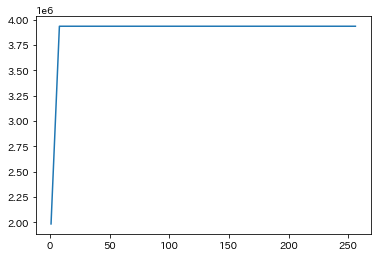

In [16]:
print(icnvrt_lin.r2_score)
print(icnvrt_lin.lr.coef_)
print(icnvrt_lin.lr.intercept_)
icnvrt_lin.plot_graph()

0.0
[[0.1800132]]
[6.33503108]


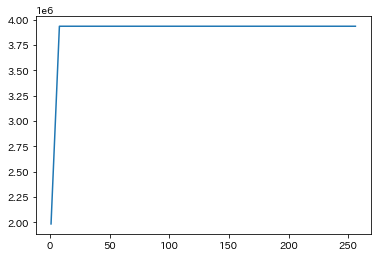

In [17]:
print(icnvrt_log10.r2_score)
print(icnvrt_log10.lr.coef_)
print(icnvrt_log10.lr.intercept_)
icnvrt_log10.plot_graph()